<a href="https://colab.research.google.com/github/AdiSk325/Music_ML_analyzing/blob/master/CNN_tonation_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [#1]  Muzyka w sieci (neuronowej)

---
## Zadanie 

> ### Budowa sieci neuronowej rozpoznającej tonację zagranego akordu
> 1. Wczytanie przygotowanych **danych**
> 2. Obróbka przy pomocy biblioteki `librosa` oraz dwóch **transformacji danych dźwiękowych**
> 3. Budowa **sieci neuronowej** z wykorzystaniem biblioteki `tensorflow.keras` dla każdej z transformacji i porównanie wyników
***

## Na początku było ...

___

Cześć!

W tym artykule chcę wam zaprezentować, jak wystartować z budową modelu ML, stosując **konwolucyjne sieci neuronowe**, który karmi się muzyką! Ale dlaczego miałbym karmić mój model muzyką i co on na jej temat miałby mi opowiedzieć? Od początku ...


Od wielu lat moje zainteresowania kręcą się wokół szeroko pojętej muzyki. Wiem, że w ogólności brzmi to jak oklepany frazes, bo przecież każdy zapytany na ulicy o swoje zainteresowania w pośpiechu odpowie -- "Muzyka!". W takim razie chciałbym nieco doprecyzować, czym jest moje "interesowanie się muzyką".

Po pierwsze, najprostsze i najpopularniejsze, to słuchanie różnej maści wykonawców i stylów. Poczynając od muzyki klasycznej (tak, mam 27 lat i lubię posłuchać Bacha), przez muzykę chóralną i liturgiczną różnych okresów, do współczesnych brzmień muzyki popularnej. I tutaj też dość szeroko, bo w moim domu usłyszycie zarówno mądry tekstowo (w subiektywnym odczuciu) polski rap oraz ciężkie brzmienie skandynawskich gitar na tle orkiestry symfonicznej. Także niezły kocioł, ku uciesze sąsiadów :)

Po drugie, to kilka życiowych przygód instrumentalnych i wokalnych. Domowy zwierzyniec instrumentów muzycznych otwierają dwie gitary, klasyczna i akustyczna, ukulele, znajdzie się również tamburyn i sławny na całym świecie trójkąt. I dwie harmonijki ustne? Albo tylko jedna? Nie umiem się doliczyć. W rodzinnym domu, zakurzona gitara basowa pamięta czasy gimnazjalnej kapeli (teraz ani kapeli, ani gimnazjum ;/). W tamtym czasie powstało kilka bluesowych ballad i bardziej skocznych kawałków, z których żaden nie wyszedł poza mury podziemnej sali prób. Obecnie, wszystkie szarpane, dęte i perkusyjne zwierzaki zaległy w szafach i kątach, by ustąpić miejsca największemu spośród nich -- mowa tu o pianinie cyfrowym dumnie eksponowanym w centralnym miejscu w mieszkaniu. To dzięki niemu moja pasja do muzyki jest aktualnie w rozkwicie i kieruje mnie do zmierzenia się z królem muzycznego ogrodu, jakim są niewątpliwie organy piszczałkowe. Ale to narazie mglista przyszłość, więc nie miejsce i czas, aby więcej o nich opowiadać. Upomnijcie się za jakiś czas :).

Wreszcie, zbliżając się do istoty tego artykułu, muzyka fascynuje mnie od swojej *t e c h n i c z n e j* strony. Od jej podstawowych zasad wykładanych w ogródkach i przedszkolach muzycznych całego świata, do matematycznych (często mocno akademickich) fundamentów cyfrowej obróbki dźwięku i zrozumienia, co dokładnie w "muzycznej trawie piszczy". 

Nie będę prawił poematów na temat muzyki, gdyż wystarczająco wielu wybitnych poetów urodziła nasza ziemia. Powiem tyle, ja znajduję w niej tak wiele inspiracji, że wreszcie przyszedł czas żeby się nimi podzielić. 
> **[Eviva l'arte](https://wolnelektury.pl/katalog/lektura/eviva-l-arte.html)**   
>
> ...   
> *I chociaż życie nasze nic nie warte:    
> Eviva l'arte!*
>
> `Kazimierz Przerwa-Tetmajer`

---

### Intro

No to zaczynamy ... na początek zaimportujmy potrzebne biblioteki.

In [1]:
#Poruszanie się po katalogach i plikach
import os

#Przygotowanie danych do modelowania
import pandas as pd 
import numpy as np
import datetime

#Analiza dźwięku zamknięta w pythonową bibliotekę
import librosa
import librosa.display

#Prezentacja dźwięku w postaci wykresów
import matplotlib.pyplot as plt

#Przygotowanie próbek train i test oraz metryka sukcesu
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score #Accuracy sprawdzi się w tym miejscu, ponieważ etykiety są równomiernie rozłożone

#Progress Bar
from tqdm import tqdm 

#Keras w kilku krokach pozwala zbudować niezłą sieć konwolucyjną
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

In [2]:
HOME_DIR = '.'
DATA_DIR = os.path.join(HOME_DIR, 'augument_data', 'labels')

### Przygotowanie danych

Dane w modelach Machine Learning (i nie tylko) to podstawa owocnej pracy. Na potrzeby tego artykułu przygotowałem surowe pliki .wav, które zawierają nagrania akordów durowych w postaci zasadniczej i pierwszym przewrocie.       

> **Sumaryczna długość nagrań wynosi aż 1 godzinę 34 minuty i 14 sekund.**

Nie oznacza to, że spędziłem pół dnia przy klawiaturze pianina i komputerze, nagrywając melodycznie brzmiące akordy -- cierpliwość Małżonki i sąsiadów ma swoje granice, a takie zachowanie bezapelacyjnie znalazłoby się poza tymi granicami. O tym, w jaki sposób ze skromnych kilkunastu krótkich nagrań stworzyć dane gotowe do uczenia maszynowego znajdziecie w moim kolejnym artykule.       

In [3]:
#########################################################################
### Wczytuje pojedynczy plik zapisany wcześniej, gdyż Colab potrzebuje### 
###       dużo czasu na pobranie osobno 2016 plików z Google Drive    ###
#########################################################################
if os.path.exists(os.path.join(DATA_DIR, 'audio_data_raw.pkl')) and os.path.exists(os.path.join(DATA_DIR, 'audio_labels_raw.pkl')):
    data_raw = pd.read_pickle(os.path.join(DATA_DIR, 'audio_data_raw.pkl'))
    labels_raw = pd.read_pickle(os.path.join(DATA_DIR, 'audio_labels_raw.pkl'))

#########################################################################
### Na lokalnym dysku działa to dość sprawnie, więc nie powinno być   ### 
###                problemu również z tym wariantem                   ###
#########################################################################
else:
    data_raw = []
    labels_raw = []
    for dirpath, dirnames, filenames in tqdm(os.walk(DATA_DIR)):
        for filename in filenames:
            sample_array, sample_rate = librosa.load(os.path.join(dirpath, filename))
            data_raw.append(sample_array)
            labels_raw.append(dirpath.split(os.path.sep)[-1])
            
    data_raw = np.array(data_raw)
    pd.to_pickle(data_raw, os.path.join(DATA_DIR, 'audio_data_raw.pkl'))
    pd.to_pickle(labels_raw, os.path.join(DATA_DIR, 'audio_labels_raw.pkl'))

Powyższy plik zajmuje prawie 0.5 GB pamięci. Zajmowanie się muzyką i Data Science jednocześnie wymaga duuuużo miejsca. A jak policzyłem długość wszystkich plików? Wygląda to tak: 

In [4]:
sample_rate = 22050
sec = int(np.array([len(sample) for sample in data_raw]).sum()/(sample_rate))
str(datetime.timedelta(seconds=sec))

'1:34:14'

In [5]:
def adjust_samples_len(samples):
    """ Funkcja wyrównująca długość przygotowanych ścieżek do najdłuższej ścieżki spośród zadanych"""
    
    max_time_in_sec = max([len(sample) for sample in data_raw])/sample_rate
    print('Najdłuższa ścieżka trwa {} s.'.format(round(max_time_in_sec,2)))
    
    result_lst = []
    for sample in samples:
        result_lst.append(np.pad(sample, (0, int(max_time_in_sec*sample_rate - len(sample))), 'constant'))
      
    return np.array(result_lst)

data = adjust_samples_len(data_raw)

Najdłuższa ścieżka trwa 4.92 s.


In [6]:
labels = pd.factorize(labels_raw)[0]
labels_names = pd.factorize(labels_raw)[1]

### Kilka słów o muzyce

[YouTube](https://www.youtube.com/watch?v=spUNpyF58BY)

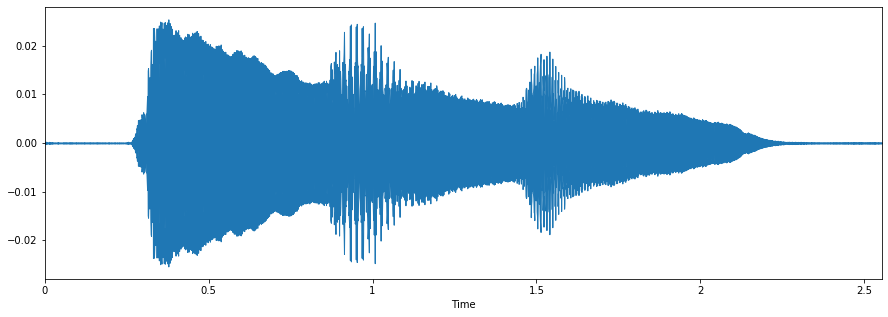

In [7]:
plt.figure(figsize=(15, 5))
librosa.display.waveplot(data_raw[0]);

In [8]:
librosa.stft(data_raw[0], n_fft=2**12, win_length=2**7).shape

(2049, 1761)

(513, 587)


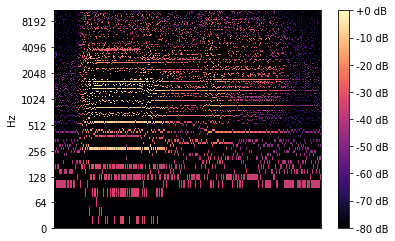

In [9]:
y, sr = data_raw[1], 22050
freqs = librosa.core.fft_frequencies(sr, n_fft=2**10)
S = np.abs((librosa.stft(y, n_fft=2**10, win_length=2**9)).real)
harms = [1, 1/2, 1/3, 1/4, 1/5, 1/6]
weights = [1,1,1,1,1,1]
S_sal = librosa.amplitude_to_db(librosa.salience(S, freqs, harms, weights, fill_value=0), ref=np.max)
print(S_sal.shape)

librosa.display.specshow(S_sal, y_axis='log', sr=sr)
plt.colorbar(format='%+2.0f dB');

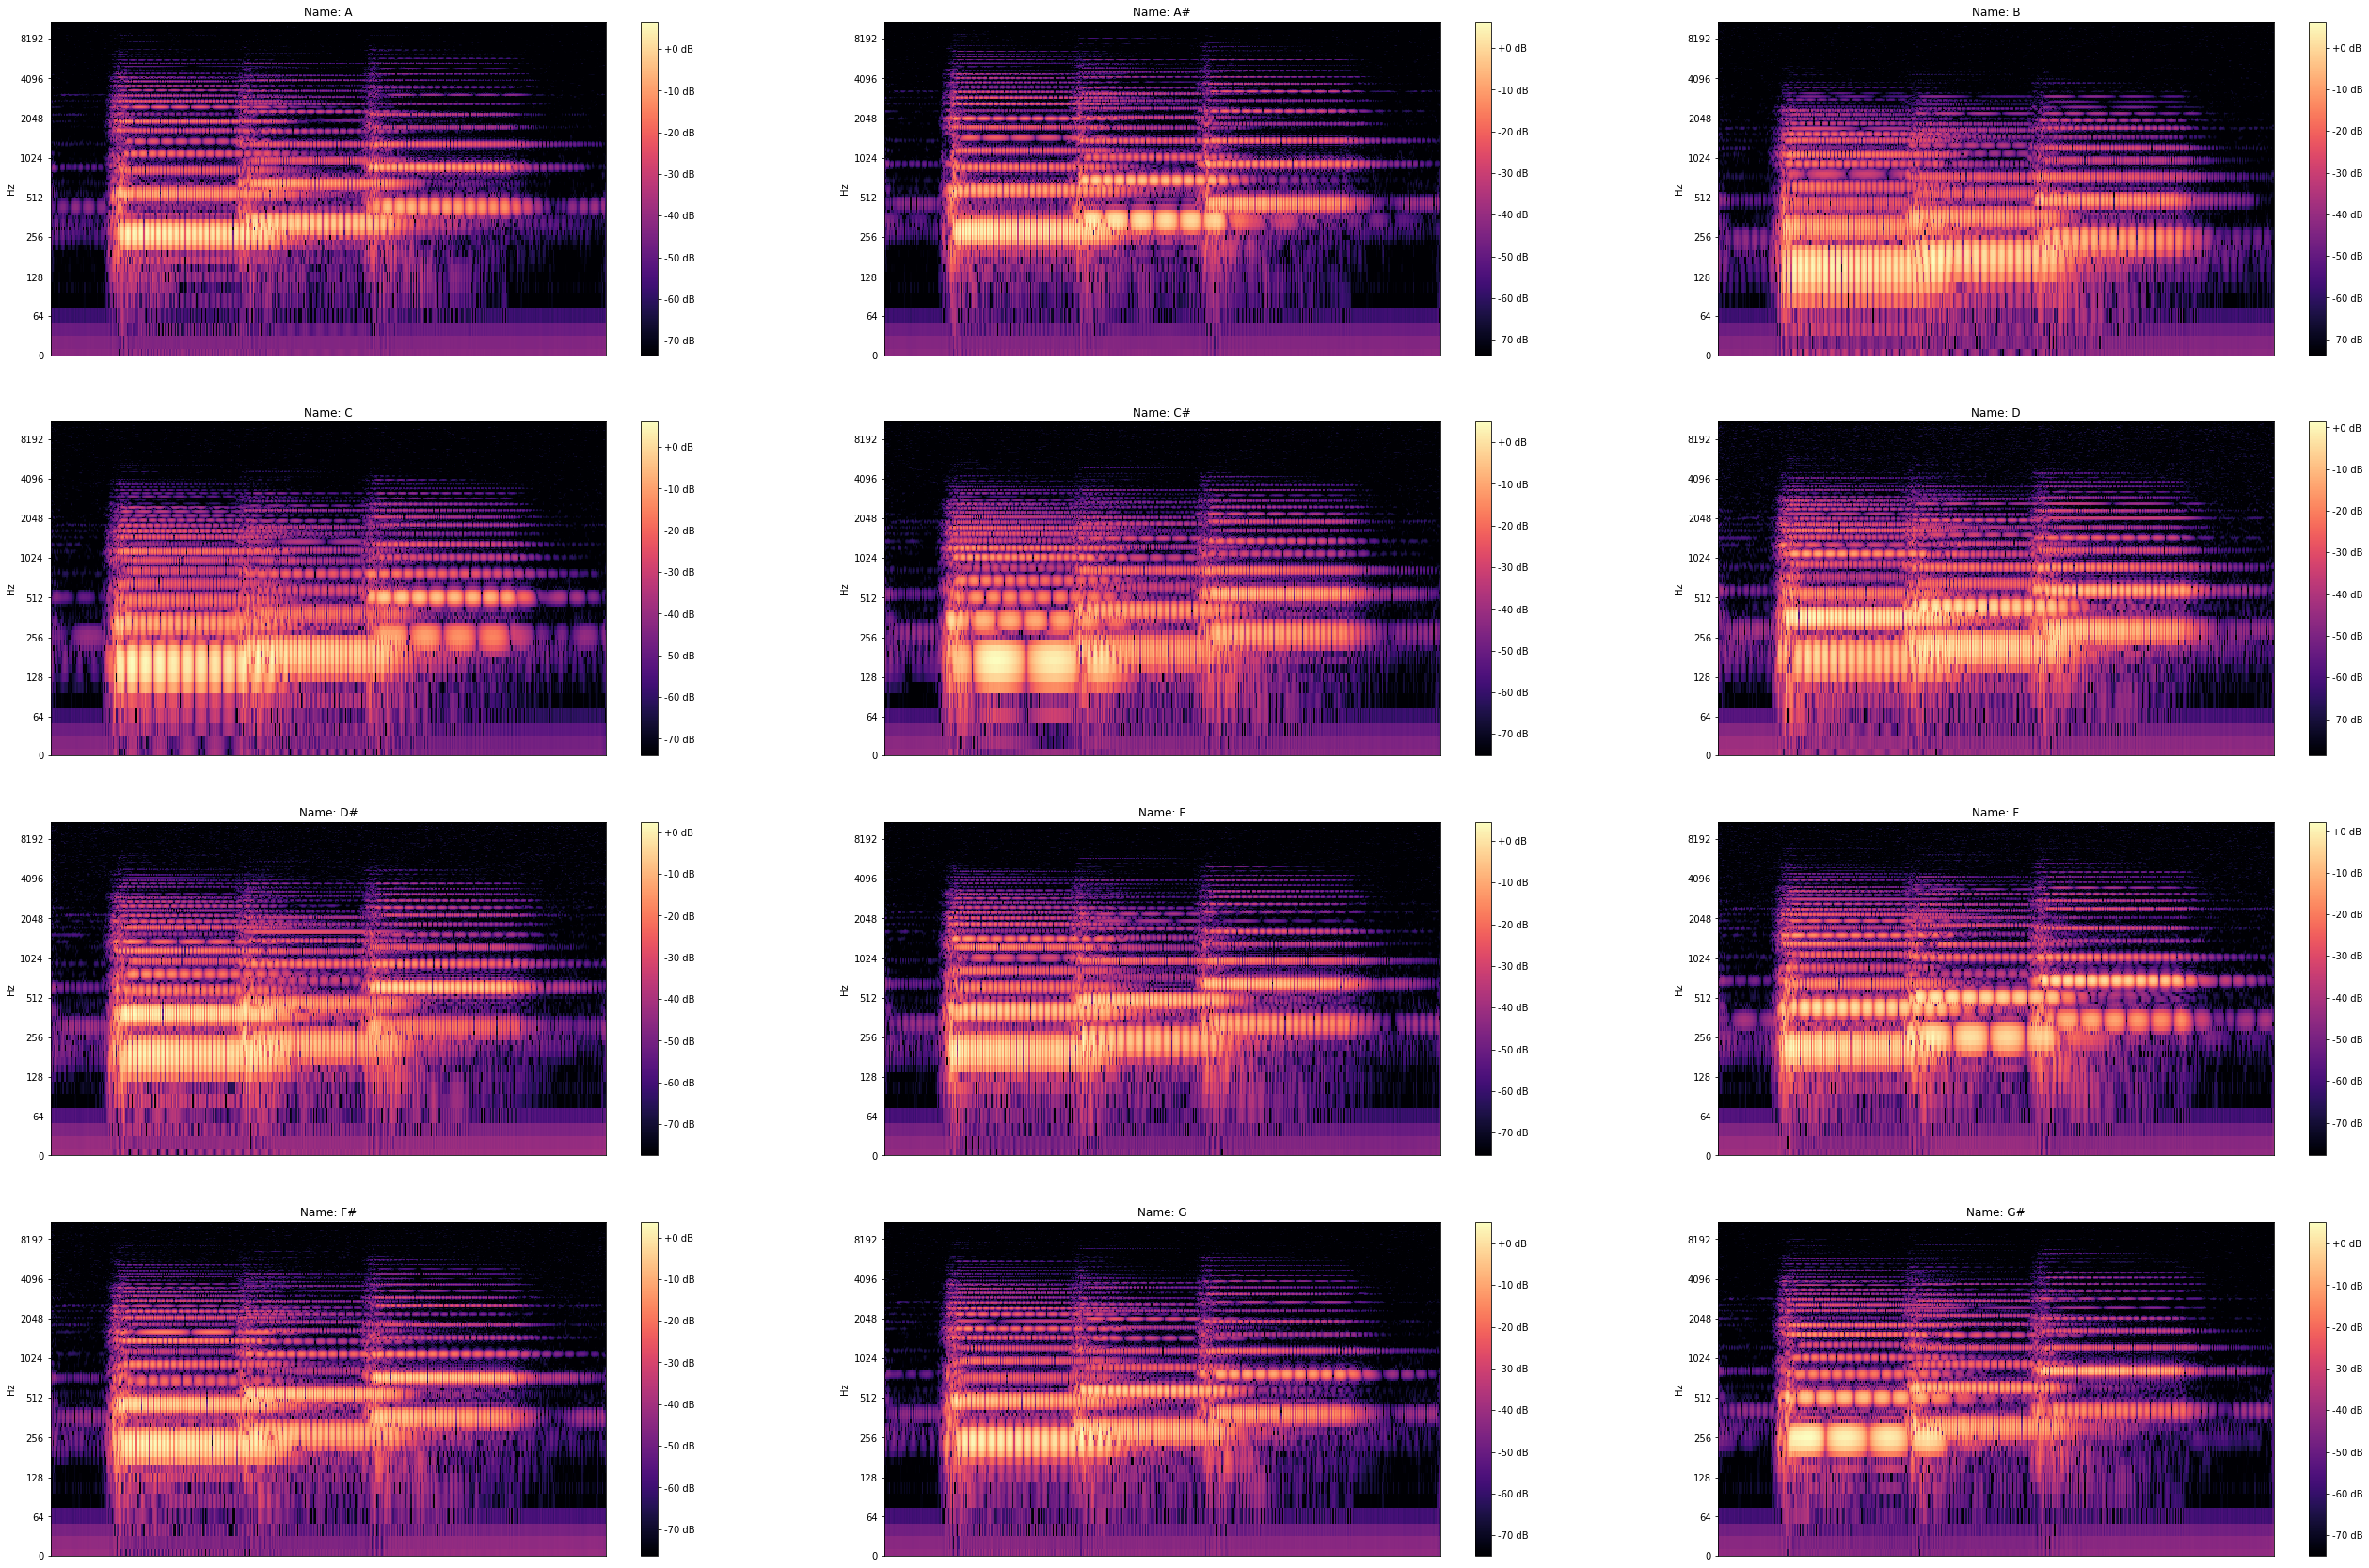

In [10]:
plt.figure(figsize=(45, 30))
for i in range(12):
    y = data_raw[168*i]
    plt.subplot(4,3,i+1)
    #C = librosa.amplitude_to_db(np.abs(librosa.stft(y, n_fft=2**9)))
    C = librosa.amplitude_to_db(np.abs(librosa.stft(y, n_fft=2**10, win_length=2**9).real))
    librosa.display.specshow(C, y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Name: {}'.format(labels_names[labels[168*i]]))

In [11]:
magnitude_raw = []
for sample in tqdm(data):
    magnitude_raw.append(librosa.amplitude_to_db(np.abs(librosa.stft(y, n_fft=2**10, win_length=2**9).real)))
magnitude_raw = np.array(magnitude_raw)

100%|█████████████████████████████████████████████████████████████████████████████| 2016/2016 [00:10<00:00, 191.20it/s]


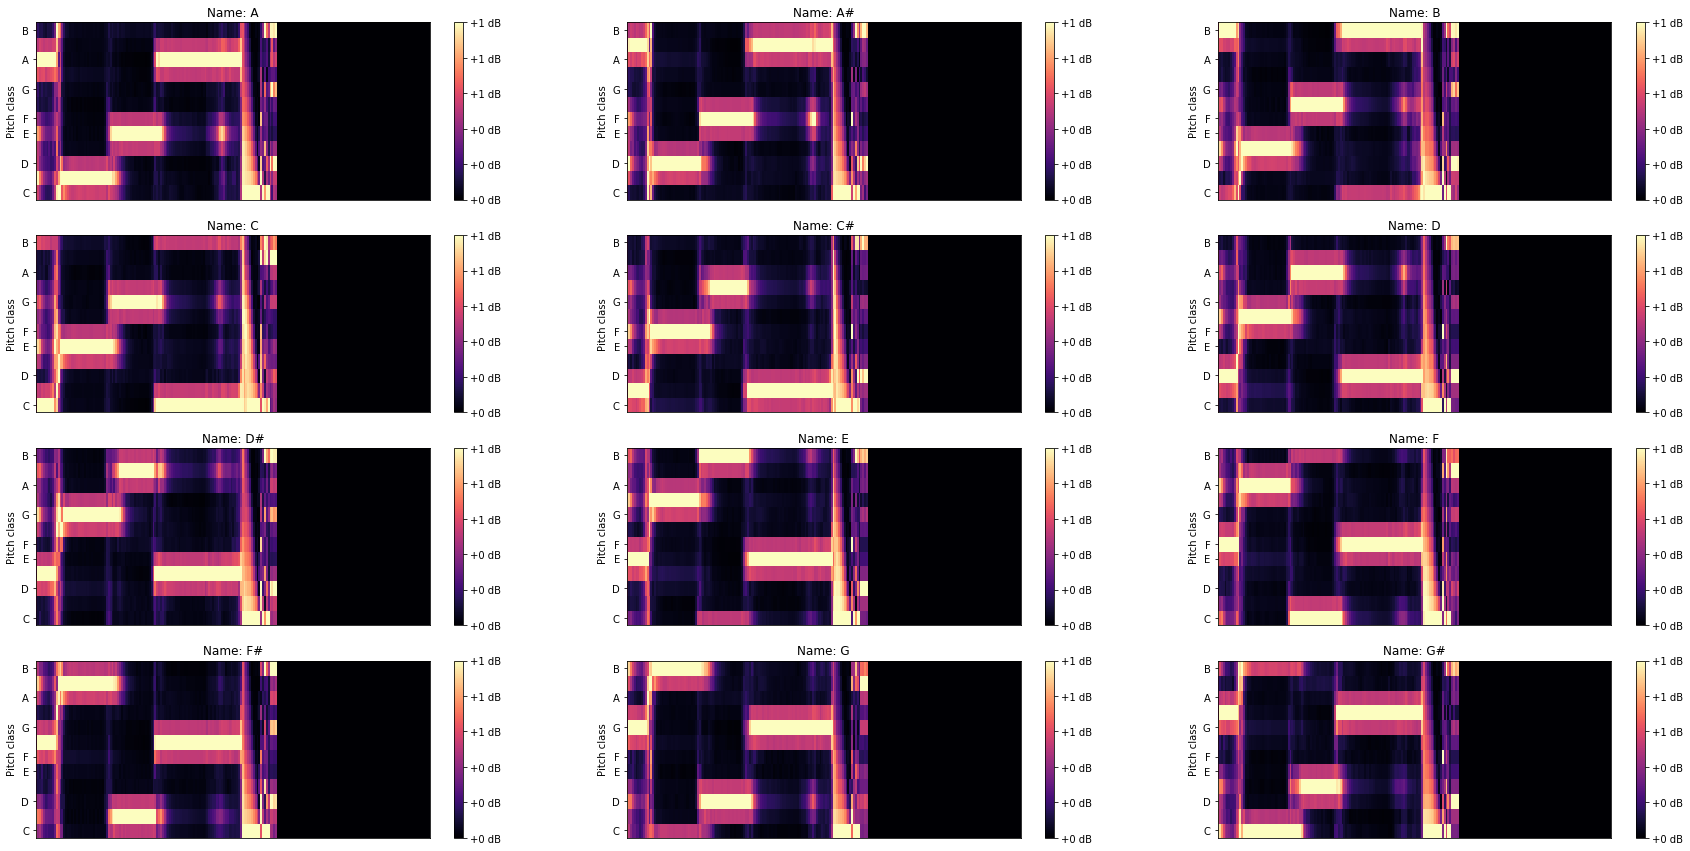

In [12]:
plt.figure(figsize=(30, 15))
for i in range(12):
    y = data[168*i]
    plt.subplot(4,3,i+1)
    C = librosa.feature.chroma_cqt(y)
    librosa.display.specshow(C, y_axis='chroma')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Name: {}'.format(labels_names[labels[168*i]]))

In [13]:
chroma_cqt_raw = []
for sample in tqdm(data):
    chroma_cqt_raw.append(librosa.feature.chroma_cqt(sample))
chroma_cqt_raw = np.array(chroma_cqt_raw)

100%|██████████████████████████████████████████████████████████████████████████████| 2016/2016 [02:35<00:00, 12.98it/s]


In [14]:
X_train, X_test, y_train, y_test = train_test_split(magnitude_raw, labels, test_size=0.2)

In [15]:
if y_train.ndim == 1: y_train = to_categorical(y_train)
if y_test.ndim == 1: y_test = to_categorical(y_test)

In [16]:
x,y,z = X_train.shape
X_train = X_train.reshape(x,y,z,1)

x,y,z = X_test.shape
X_test = X_test.reshape(x,y,z,1)

In [17]:
input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]

In [18]:
input_shape

(513, 441, 1)

In [19]:
def get_cnn_for_magnitude(input_shape, num_classes):
    return Sequential([
    Conv2D(filters=128, kernel_size=(50,50), strides=(3,3), activation='relu', input_shape=input_shape),
    Conv2D(filters=64,  kernel_size=(30,30),  strides=(2,2), activation='relu', input_shape=input_shape), 
    MaxPool2D(),
    Dropout(0.4),

    Conv2D(filters=32, kernel_size=(4,4), activation='relu', input_shape=input_shape),
    MaxPool2D(),
    Dropout(0.3),
    
    Flatten(),
    Dense(num_classes, activation='softmax'),
])
    
def get_cnn_for_chroma_cqt(input_shape, num_classes):
    return Sequential([
    Conv2D(filters=32, kernel_size=(8,8), activation='relu', input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(4,4), activation='relu', input_shape=input_shape), 
    MaxPool2D(),
    Flatten(),
    Dropout(0.4),    
            
    Dense(num_classes, activation='softmax'),
])
  
def train_model(model, X_train, y_train, params_fit={}):
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    #logdir = os.path.join(HOME_DIR, "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    #tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
  
    model.fit(
          X_train,
          y_train,
          batch_size = params_fit.get('batch_size', 64),
          epochs = params_fit.get('epochs', 5),
          verbose=params_fit.get('verbose',1),
          validation_data = params_fit.get('validation_data', (X_train, y_train)),
          #callbacks= [tensorboard_callback]
          )
    
def predict(model_trained, X_test, y_test, scoring=accuracy_score):
    y_test_norm = np.argmax(y_test, axis=1)
    y_pred_prob = model_trained.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    return scoring(y_test_norm, y_pred) 

In [ ]:
model = get_cnn_for_magnitude(input_shape, num_classes)
#model = get_cnn_for_chroma_cqt(input_shape, num_classes)
train_model(model, X_train, y_train)

Train on 1612 samples, validate on 1612 samples
Epoch 1/5
  64/1612 [>.............................] - ETA: 45:38 - loss: 15.4756 - accuracy: 0.1250

In [ ]:
predict(model, X_test, y_test)

In [ ]:
print(labels_names[np.argmax(model.predict(X_test)[0])])
print(labels_names[y_test[0].argmax()])

In [ ]:
model.summary()